In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def grayscale2(img):
    gray = img[:, :, 0].astype('int16') + img[:, :, 1].astype('int16') - img[:, :, 2].astype('int16') 
    gray[gray > 255] = 255
    gray[gray < 0] = 0
    return gray.astype('uint8')
    


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Project: Finding lane lines on the road

## 1. Original pictures

First let's have a look at the original pictures. Besides the six test images provided by Udacity I added two images myself. Those are taken from the "challenge" video which is part of the repository as well. Exploring the inital six images one can highlight the following observations:
* all lane lines are straight 
* they always appear in the same general region of the image
* lane lines are painted in high contrast color to the road surface (either white or yellow) 
* light conditions are similar

Things become more challenging with the two images of the "challenge" video.
* slight curvature of lane lines
* light conditions vary because of shadows or bright sunlight
* other cars are much closer
* a part of the car is visible in the bottom of the picture

We need to develop a algorithm which is general as well as robust to detect lane lines reliabely under varying conditions. 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [44]:
def display_images(images, figsize = (15, 10)):
    "Display images in two columns. Chooses gray-scale colorbar if image is two-dimensional."
    ncols = 2
    nrows = (len(images) // 2) + (len(images) % 2) 
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

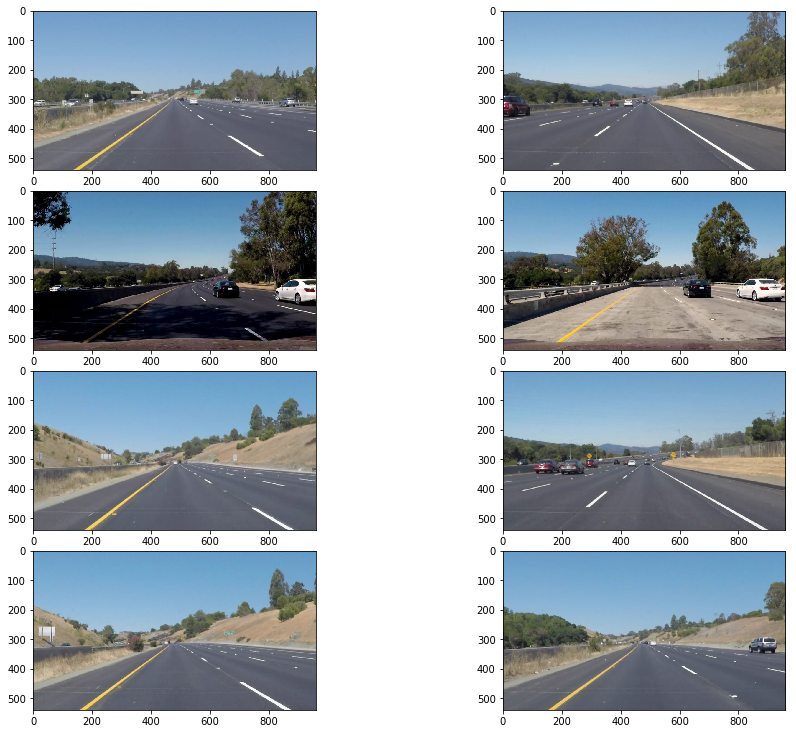

In [45]:
# import images
import glob

images = [mpimg.imread(image) for image in glob.glob("test_images/*.jpg")]

display_images(images)

## 2. Regions selection

The region selection seems to be straight forward because all lane lines appear in the same general region of the pictures. The choice of the region has to take into account that a part of the car is visible at the bottom of some pictures. A polygon with four sides is a reasonable choice. It shouldn't be too restrictive. Objects which fall in this region but are not related to lane lines can still be suppressed through an appropriate filtering algorithms and a tuning of Cany and Hough algorithms.

Each original picture has a size of 540x960. I chose the region between 330 and 490 in x-direction and the full length in y-direction.

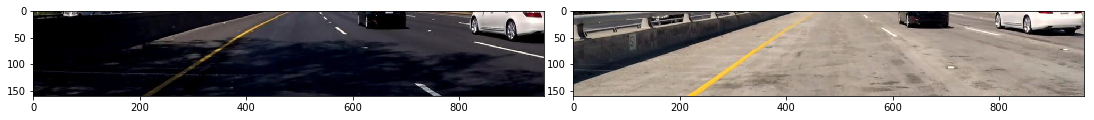

In [72]:
images_reg = np.copy(images)

images_reg = [img[330:490][:] for img in images]

display_images(images_reg[2:4])

## 3. Grayscale transformation

The Cany edge-detection algorithm expects a grayscale image as input. Typically the following formula is applied to conduct grayscale conversion from RGB colorspace
$$Gray = 0.299\cdot R + 0.587\cdot G + 0.114\cdot B.$$
Lane line markings are painted in high contrast colors (white, yellow, red) to the dark road surface. It would be  	advantageous for the application of the Cany algorithms (allows to set higher thresholds) if we choose a transformation which enhances the contrast between a dark pixel and a yellow/white/red pixel. This can be achieved through 
$$Gray = R + G - B.$$

As illustrated in the following toy problem the contrast (i.e. difference in intensities) betweeen white/yellow/red pixels and gray/black pixels is significantly enhanced using $R+G-B$ compared to $0.299\cdot R + 0.587\cdot G + 0.114\cdot B$.

Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:
white: 255   yellow: 226   red: 76   gray: 140   black: 0
Intensity values of image after grayscale transformation R+G-B:
white: 255   yellow: 255   red: 255   gray: 140   black: 0


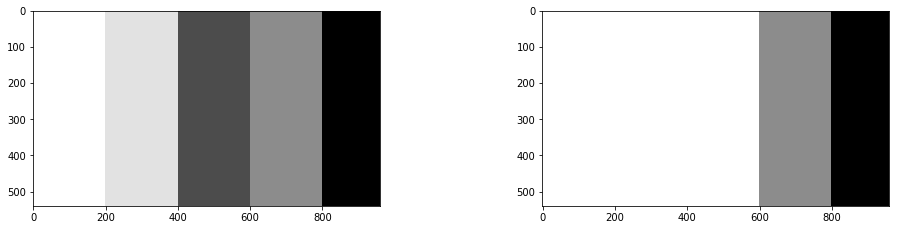

In [73]:
def grayscale(img):
    "Applies the Grayscale transform according to 0.299*R+0.587*G+0.114*B."
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def grayscale2(img):
    "Applies the Grayscale transform according to R+G-B."
    gray = img[:, :, 0].astype('int16') + img[:, :, 1].astype('int16') - img[:, :, 2].astype('int16') 
    gray[gray > 255] = 255
    gray[gray < 0] = 0
    return gray.astype('uint8')


# create picture with white, yellow, red, gray and black regions
imgo = np.zeros_like(np.copy(images[0]))
imgo[:, 0:200]   = [255, 255, 255]
imgo[:, 200:400] = [255, 255, 0]
imgo[:, 400:600] = [255, 0, 0]
imgo[:, 600:800] = [140, 140, 140]
imgo[:, 800:]    = [0, 0, 0]

# grayscale conversion
img_g1 = grayscale(imgo)
img_g2 = grayscale2(imgo)

# intensity values
print('Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g1[1, 150], img_g1[1, 250], img_g1[1, 450], img_g1[1, 650], img_g1[1, 850]))
print('Intensity values of image after grayscale transformation R+G-B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g2[1, 150], img_g2[1, 250], img_g2[1, 450], img_g2[1, 650], img_g2[1, 850]))

display_images([img_g1, img_g2], figsize = (15, 3))

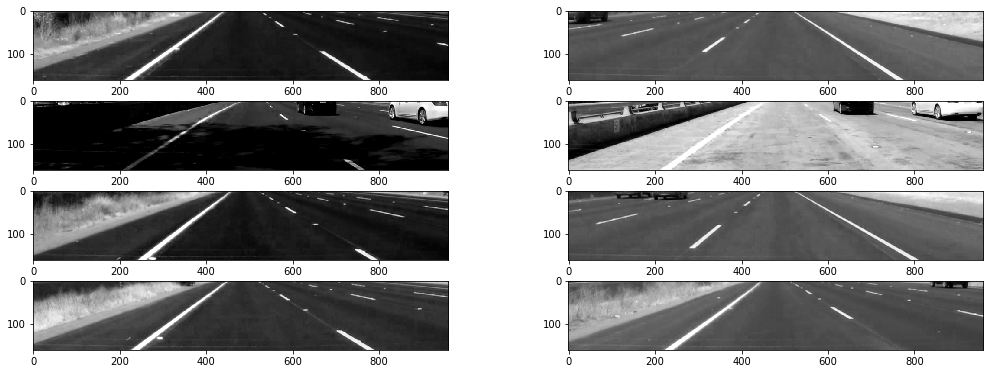

In [74]:
images_gray = np.copy(images_reg)   

images_gray = [grayscale2(image) for image in images_gray]

display_images(images_gray, figsize = (15, 5))

## 4. Canny edge detection

Next we apply the Canny edge detection algorithm to the images. The algorithm consits of four steps
* apply a Gaussian filter in order to smooth the image 
* compute magnitude of the gradient vector for each pixel
* apply a double thresholding to the gradient
    * if gradient is larger than high threshold pixel is regarded as an edge
    * if gradient is smaller than the low threshold pixel is disgarded
    * if gardient is between high and low threshold pixel is marked as a potential edge
* check if "potential edge" pixels are connected to strong edges
    * if yes: regard them as edges
    * if no: disgard them
The algorithm tries to preserve pixels with high gradient values while filtering out pixels with low gradient values.

Since lane line marking are painted with a high contrast color to the road surface (we even enhanced this contrast with our choice of the grayscale conversion) we have a good chance to detect them even with high thresholds. It is important to choose optimize threhsolds such that lane lines are still detect and noisy edges (i.e. edges which are related to line lines) are suppressed as much as possible. The thresholds have to be adjusted empirically. Canny himself recommends a ratio between 1:2 and 1:3 for the low and high threshold. Thresholds low_thresh = 100 and high_thresh = 150 work best for the problem at hand.

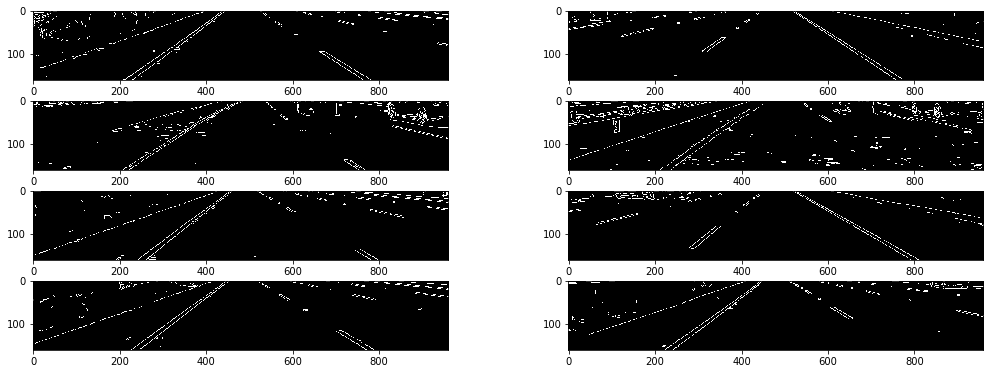

In [75]:
def canny(img, low_thresh, high_thresh):
    "Applies the Canny transform."
    return cv2.Canny(img, low_thresh, high_thresh)

images_canny = [canny(image, 100, 150) for image in images_gray]

display_images(images_canny, figsize = (15, 5))

## 5. Edge filtering based on edge orientation

Despite the optimization of high and low thresholds many noisy edges are still present in the figures. These edges cannot be filtered out through a proper choice of thresholds alone. We try to filter out the remaining noisy edges by exploting specific knowledge about lane lines. 

Typical lane lines have an angle with respect to the y-axis in the interval [15$^{\circ}$:165$^{\circ}$]. Any line which doesn't fall in this range is most likely a noisy edge. Based on this oberservation we developed an algorithm to filter out edges with an unusal low (or high) angle with respect to the y-axis.  

First the image is divided in a grid of quadratical subimages with a size of 20x20 pixels. Next the Hough transform is applied to each subimage in order to find all lines. The angle of each line with respect to the y-axis and its magnitude is computed afterwards. If the angle is not in the interval [15$^{\circ}$:165$^{\circ}$] the line is assigned to class 'no lane marking' otherwise to class 'lane marking'. Finally the sum of magnituds of all lines in class 'no lane marking' are compared to the sum of magnituds of all lines in class 'lane marking'. If the sum of class 'no lane marking' is larger than the one of class 'lane marking' the subimage is zeroed assuming that no lane line marking is contained in it. Otherwise the subimage is kept as is.

In [197]:
def subimage(image, size):
    """Return list of all sub-images. Each sub-image is represented by a tuple (sx1, sx2, sy1, sy2) such that
    image[sx1:sx2, sy1:sy2] gives the slice of the sub-image.
    
    Args:
    image -- image to be devided
    size  -- size of sub-image (sizexsize pixels). Size has to be a factor of xdim and ydim of image."""
    xdim, ydim = image.shape
    assert (xdim%size==0) and (ydim%size==0), '???'
    nrow = ydim // size
    ncol = xdim // size
    return [(size*x, size*(x+1), size*y, size*(y+1))  for x in range(ncol) for y in range(nrow)]

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """Return an array of lines found by the Hough transform [[x1, y1, x2, y2], ...].
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line
    """
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def add_hough_lines(image, lines, color=[255, 0, 0], thickness=1):
    """Return image with lines drawn on image.
    
    Args:
    image     -- original image
    lines     -- array of lines [[x1, y1, x2, y2], ...] (e.g. output of cv2.HoughLinesP)
    color     -- color of line (default: red)
    thickness -- thickness of line (default: 1)
    """
    # create color binary image
    imgl = np.zeros_like(image, dtype=np.uint8)
    if len(image.shape)==2:
        imgl = np.dstack((imgl, imgl, imgl))   
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(imgl, (x1, y1), (x2, y2), color, thickness) 
    return imgl

First we have to look for good values for the Hough transform. Again these parameters are found empirically. The Hough transformation hough_transform(rho, theta, threshold, min_line_len, max_line_gap) takes six parameters

* image: binary image (e.g. output of the Canny function of opencv)
* rho: distance resolution in pixels 
* theta: angle resolution in radiands
* threshold: threshold + 1 is the minimum number of votes a line needs to be returned
* min_line_len: minimum length of a line needed to be returned
* max_line_gap: maximum distance of two line segments to be considered as a single line

Again one needs to find a compromise between filtering out noisy lines and not filtering out real lines. A Hough transformation with parameters rho=1, theta=np.pi/180, threshold=10, min_line_len=5, max_line_gap=5 turned out to be good choice.

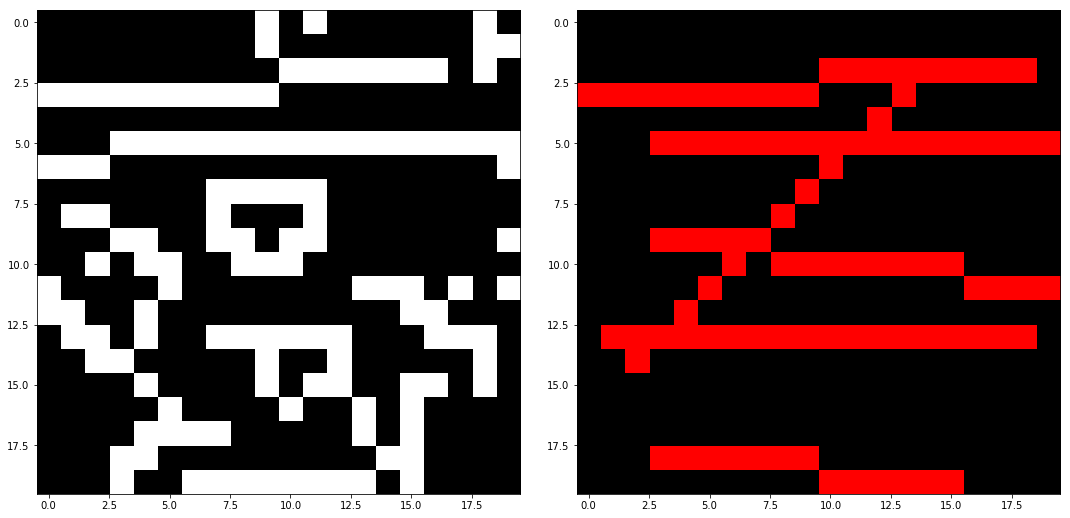

In [185]:
img = images_canny[0][0:20, 0:20]

lines = hough_lines(img, rho=1, theta=np.pi/180, threshold=10, min_line_len=5, max_line_gap=5)
img2 = add_hough_lines(img, lines, color=[255, 0, 0], thickness=1)

display_images([img, img2], figsize = (15, 7))

The next chunk of code implements the filtering algorithm based on edge orientation.

In [215]:
def angle(v1, v2):
    "Return angle between vectors v1 and v2 in degrees."
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi

def sum_max_magn(v1, v2):
    "Return sum of vectors v1 and v2 such that the magnitude of the result vector is maximized."
    a = v1 + v2
    b = v1 - v2
    return a if np.linalg.norm(a) >= np.linalg.norm(b) else b

def line_vectors(image, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return two vectors: One representing the sum of all lines with an angle in range [thrAngle:180-thrAngle] with 
    respect to the y-axis and a sencond one for all lines in range [0:thrAngle] || [thrAngle:180-thrAngle]. 
    
    Return None for nl and/or ll if no line in the expected angular range was found.
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    nl           -- sum of all lines with an angle in range [0:thrAngle] || [thrAngle:180-thrAngle]
    ll           -- sum of all lines with an angle in range [thrAngle:180-thrAngle]
    """
    assert image.shape != (0, 0)
    lines = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)  
    nl = np.array([0, 0])
    ll = np.array([0, 0])
    if lines is None: # hough returns None if no lines were found (i.e. don't change original figure)
        return None, None
    ex = np.array([0, 1])
    for line in lines:
        x1, y1, x2, y2 = line[0] 
        el = np.array([y1, x1]) - np.array([y2, x2]) # numpy and opencv interchange rows and columns
        if (angle(el, ex) <= thrAngle) or (angle(el, ex) >= 180-thrAngle):
            nl = sum_max_magn(nl, el) 
        else:
            ll = sum_max_magn(ll, el) 
    if np.array_equal(nl, np.array([0, 0])):
        nl = None
    if np.array_equal(ll, np.array([0, 0])):
        ll = None    
    return nl, ll


def setup_grid(image, size, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return grid of sub-images with boolean value indicating if subimage contains potential lane line.

    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    size         -- size of sub-images
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    grid         -- Dictonary with keys indicating sub-image and boolean values indicating if sub-image contains lane line.
                    {(x1, x2, y1, y2) : True, (x1, x2, y1, y2): False, ...}
    """
    subs = subimage(image, size)
    grid = {}
    for sub in subs:
        x1, x2, y1, y2  = sub
        nl, ll = line_vectors(image[x1:x2, y1:y2], thrAngle, rho, theta, threshold, min_line_len, max_line_gap)
        if ll is None:
            grid[(x1, x2, y1, y2)] = False
        elif nl is None:
            grid[(x1, x2, y1, y2)] = True             
        elif np.linalg.norm(ll) >= np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = True            
        elif np.linalg.norm(ll) < np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = False 
    return grid    

def heatmap(image, grid):
    """Return image where sub-images with lane=True are highlighted in white (useful to visualize result of setup_grid)."""
    img = np.zeros_like(image)
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if lane:
            img[x1:x2, y1:y2] = 255 
    return img

def filter_edge_orientation(image, grid):
    """Zeros all sub-images of image (as specified by grid) with lane=False
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    grid         -- output of setup_grid
    """
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if not lane:
            image[x1:x2, y1:y2] = 0

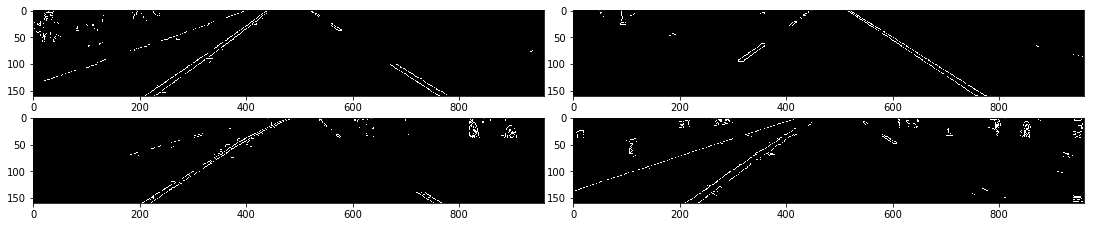

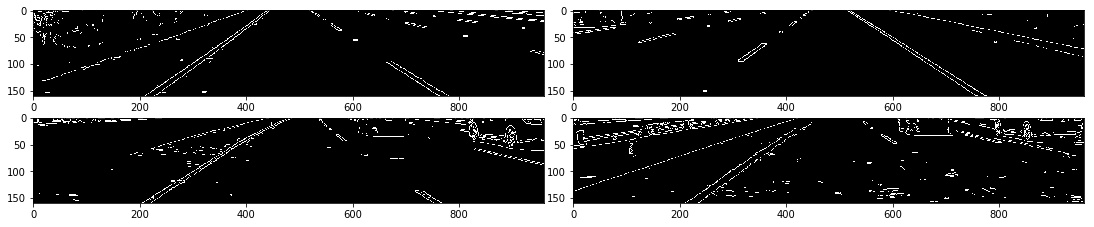

In [288]:
images_filter_eo = np.copy(images_canny)

grids = [setup_grid(image, size = 20, thrAngle = 15, rho = 1, theta = np.pi/180, threshold = 7, 
                    min_line_len = 5, max_line_gap = 5) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]

#display_images(heatmaps[0:4], figsize = (15, 3))
display_images(images_filter_eo[0:4], figsize = (15, 3))
display_images(images_canny[0:4], figsize = (15, 3))

The filtering algorithm based on edge orientation works very well. A good portion of noisy edges has been filtered out. However, sometimes a sub-image is zeroed although it contained a piece of the actual lane line marking. In order to fix this issue we apply a mask which looks at the nei

In [259]:
def reconstruct_lane(grid, size):
    """Reconstruct grid: If neighbouring top left, top right or top sub-images contains line lane
    assume sub-image contains line lane as well."""
    agrid = grid.copy() # copy dict
    for coo, lane in grid.items():
        for neigh in neighbours(coo, size):
            if neigh in grid.keys() and grid[neigh]==True:
                agrid[coo] = True
    return agrid        
        
def neighbours(coo, size):
    "Return coordinates of the neighbouring sub-images on the top left, topright and top."
    x1, x2, y1, y2 = coo
    top = (x1 + size, x2 + size, y1, y2)
    topleft = (x1 + size, x2 + size, y1 - size, y2 - size)   
    topright = (x1 + size, x2 + size, y1 + size, y2 + size)
    return (topleft, top, topright)

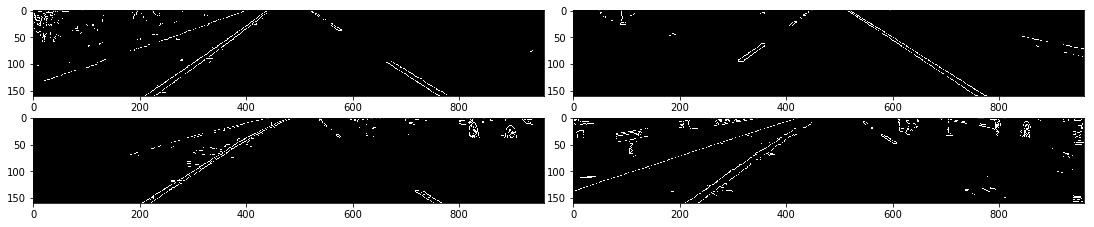

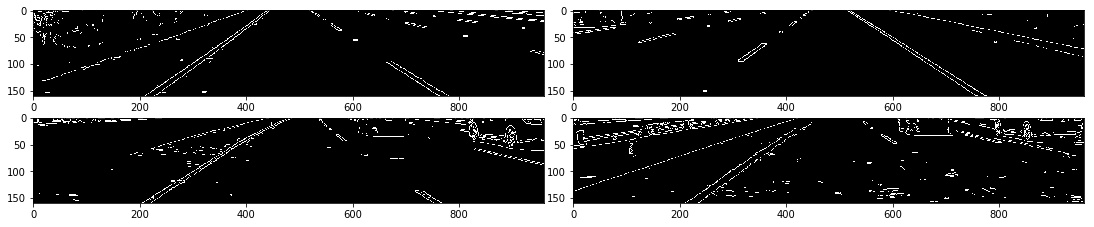

In [299]:
images_filter_eo = np.copy(images_canny)

grids = [reconstruct_lane(setup_grid(image, size = 20, thrAngle = 15, rho = 1, theta = np.pi/180, 
                                     threshold = 7, min_line_len = 5, max_line_gap = 5), size = 20) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]


#display_images(heatmaps[0:4], figsize = (15, 3))
display_images(images_filter_eo[0:4], figsize = (15, 3))
display_images(images_canny[0:4], figsize = (15, 3))

On the expense of some additional noisy edges the lane lines have been reconstructed.

## 6. Edge filtering based on gradients

Although the previous algorithm filtered out many noisy edges there are still some present. We exploit two additional feature of lane line markings to distinguish them from noisy edges:
* lane line marking consists of two parallel lines (after application of the Cany edge detector)
* the direction of the gradient vector at the location of the lane lines falls in four ...

In [322]:
def phase(image):
    """Return angle of gradient vector at location of each pixel. Expects a gray-scale image.
    Angles are assigned to four quadrantes represented by integers between 1 and 4. 
    1: 270 <= angle <= 360
    2: 180 <= angle <  270
    3: 90  <= angle <  180
    4: 0   <= angle <   90
    """
    gradientX = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    gradientY = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    angle = cv2.phase(gradientX, gradientY, angleInDegrees=True) 
    angle[(0 <= angle[:, :]) & (angle[:, :] < 90)]    = 4 
    angle[(90 <= angle[:, :]) & (angle[:, :] < 180)]  = 3
    angle[(180 <= angle[:, :]) & (angle[:, :] < 270)] = 2
    angle[(270 <= angle[:, :]) & (angle[:, :] <= 360)] = 1
    return angle    
    
def filter_pos_y(iq, fq, size, angle):
    """Check if pixel 'fq' is within 'size' pixels of pixel 'iq'. Otherwise zero pixel 'iq'.
    
    Search is done in increasing y-direction.    
    
    Args:
    iq -- quadrant of starting pixel
    fq -- quadrant we are looking for
    size -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    xmax, ymax = angle.shape
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] + size, 1) :
            if y < ymax and angle[pix[0], y] == fq:
                flag = True
        if not flag:
            angle[pix[0], pix[1]] = 0

def filter_neg_y(iq, fq, size, angle):
    """Check if pixel 'fq' is within 'size' pixels of pixel 'iq'. Otherwise zero pixel 'iq'.
    
    Search is done in decreasing y-direction.
    
    Args:
    iq -- quadrant of starting pixel
    fq -- quadrant we are looking for
    size -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    xmax, ymax = angle.shape
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] - size, -1):
            if y >= 0 and angle[pix[0], y] == fq:
                flag = True
        if not flag:
            angle[pix[0], pix[1]] = 0

def filter_gradient(imageg, image, width):
    """Filter out noisy edges of image based on assumptions of lane line markig width and direction of the gradient.
    
    Args:
    imageg       -- grayscale image
    image        -- binary image (e.g. output of the Canny function of opencv)
    width        -- maximum width of lane line         
    """
    angle = phase(imageg)
    mask = (image[:, :] == 255)
    angle[~mask] = 0
    filter_pos_y(iq = 1, fq = 3, size = width, angle = angle)  
    filter_pos_y(iq = 4, fq = 2, size = width, angle = angle)  
    filter_neg_y(iq = 3, fq = 1, size = width, angle = angle)  
    filter_neg_y(iq = 2, fq = 4, size = width, angle = angle) 
    xmax, ymax = angle.shape
    centerY = ymax // 2
    mask = (angle[:,0:centerY] == 1) | (angle[:,0:centerY] == 3) |  (angle[:,centerY:] == 2)  | (angle[:,centerY:] == 4)
    angle[mask] = 0
    #angle[angle != 0] = 255
    return angle.astype('uint8')
   

In [323]:
images_filter_g = [filter_gradient(i1, i2, 30)  for i1, i2 in zip(images_gray, images_filter_eo)]         
        
    
display_images(images_filter_g)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 960 but corresponding boolean dimension is 480

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))